In [1]:
import glob
import ast
import os, re
from collections import defaultdict
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
pattern = "./consolidated cracks/*.txt"
rows = []

DATE_RE = re.compile(r"^\d{4}-\d{2}-\d{2}$")

In [3]:
for filepath in sorted(glob.glob(pattern)):
    filename = os.path.basename(filepath)
    date_str = filename.replace(".txt", "")
    year = date_str.split("-")[0]

    # Read file
    with open(filepath, "r") as f:
        file_content = f.read().strip()

    # Parse safely
    try:
        cracks_dict = ast.literal_eval(file_content)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Flatten cracks into rows
    for crack_name, coords_list in cracks_dict.items():
        for lat, lon in coords_list:
            rows.append([year, date_str, crack_name, lat, lon])

# Create DataFrame
df = pd.DataFrame(rows, columns=["year", "date", "crack", "lat", "lon"])

print(df.head())
print(f"Total rows: {len(df)}")

   year        date    crack        lat         lon
0  2014  2014-05-19  Crack 1  67.010664 -162.132102
1  2014  2014-05-19  Crack 1  67.008640 -162.129449
2  2014  2014-05-19  Crack 1  67.006616 -162.126797
3  2014  2014-05-19  Crack 1  67.004592 -162.124146
4  2014  2014-05-19  Crack 1  67.001028 -162.129183
Total rows: 4248


In [4]:
import math 

def segment_bearing_deg(lat1, lon1, lat2, lon2):
    """Initial great-circle bearing from (lat1,lon1) to (lat2,lon2), in [0,360)."""
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δλ = math.radians(lon2 - lon1)
    x = math.sin(Δλ) * math.cos(φ2)
    y = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(Δλ)
    θ = math.degrees(math.atan2(x, y))
    return (θ + 360.0) % 360.0

def axial_mean_orientation_deg(bearings_deg, weights):
    """
    Length-weighted axial (0≡180) mean of bearings (in degrees).
    Returns angle in [0,180).
    """
    # Double the angles for axial data, average on the circle, then halve.
    ang2 = np.radians(2.0 * np.asarray(bearings_deg))
    w = np.asarray(weights, dtype=float)
    C = np.sum(w * np.cos(ang2))
    S = np.sum(w * np.sin(ang2))
    mean2 = math.atan2(S, C)            # in [-π, π]
    mean_axial = math.degrees(0.5 * mean2)
    if mean_axial < 0:
        mean_axial += 180.0
    return mean_axial

In [5]:
from geopy import distance

grouped = df.groupby(["date", "crack"])
rows = []

for (date, crack), group in grouped:
    lats = group["lat"].tolist()
    lons = group["lon"].tolist()

    length = 0
    segment_lengths = []
    segment_bearings = []

    for i in range(1, len(lats)):
        p1 = (lats[i-1], lons[i-1])
        p2 = (lats[i], lons[i])
        length += abs(distance.distance(p1,p2).km)
        segment_lengths.append(abs(distance.distance(p1,p2).km))
        segment_bearings.append(segment_bearing_deg(p1[0], p1[1], p2[0], p2[1]))
    bearings = segment_bearings
    rows.append([date, crack, length, bearings])

lo = pd.DataFrame(rows, columns=["date", "crack", "length", "bearings"])
print(lo)

           date    crack     length  \
0    2014-05-19  Crack 1  25.220296   
1    2014-05-19  Crack 2   9.604793   
2    2014-05-19  Crack 3  12.397510   
3    2014-05-19  Crack 4   7.437702   
4    2014-05-19  Crack 5   4.296533   
..          ...      ...        ...   
101  2025-06-09  Crack 4   5.295195   
102  2025-06-09  Crack 5   6.318529   
103  2025-06-09  Crack 6   5.515795   
104  2025-06-09  Crack 7  10.947978   
105  2025-06-09  Crack 8   2.824965   

                                              bearings  
0    [152.89189115832357, 152.89454600640966, 152.8...  
1    [99.7300956415271, 99.73721316263214, 202.7489...  
2    [300.6194660987184, 300.61354243242215, 300.60...  
3    [129.33432644995577, 129.33921581711172, 129.3...  
4    [212.779282512309, 212.7756437752083, 212.7720...  
..                                                 ...  
101  [65.69241290935474, 65.69769825862221, 65.7029...  
102  [243.24436193137262, 243.23916511516182, 243.2...  
103  [53.258942507

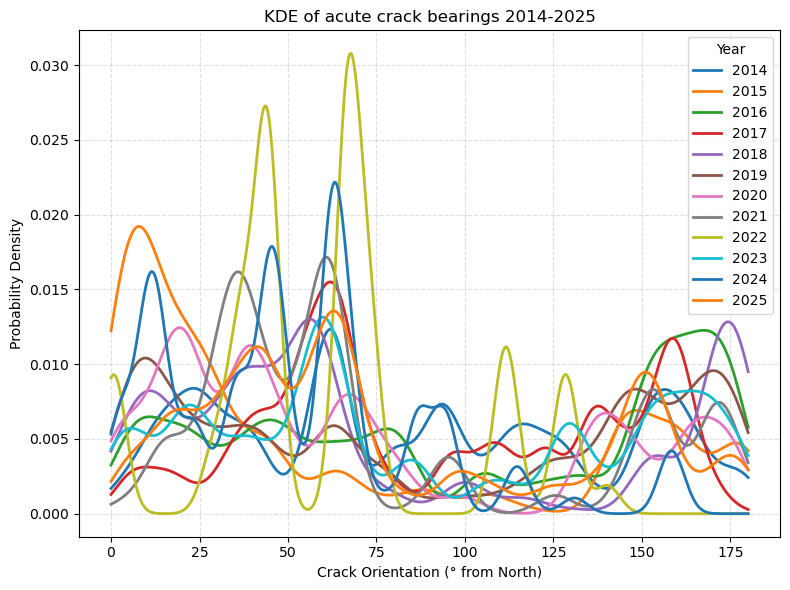

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# assuming lo DataFrame has ["date", "crack", "length", "bearings"]
lo["year"] = pd.to_datetime(lo["date"]).dt.year

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors

for i, (year, group) in enumerate(lo.groupby("year")):
    bearings = np.concatenate(group["bearings"].values)
    bearings = bearings[np.isfinite(bearings)]
    if len(bearings) == 0:
        continue

    bearings_half = bearings % 180  # map to 0–180°

    # --- smooth PDF using Gaussian KDE (non-circular) ---
    kde = gaussian_kde(bearings_half, bw_method=0.1)  # smaller bw = more detailed, larger = smoother
    x = np.linspace(0, 180, 500)
    density = kde(x)

    plt.plot(x, density, color=colors[i % len(colors)], lw=2, label=str(year))

plt.xlabel("Crack Orientation (° from North)")
plt.ylabel("Probability Density")
plt.title("KDE of acute crack bearings 2014-2025")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



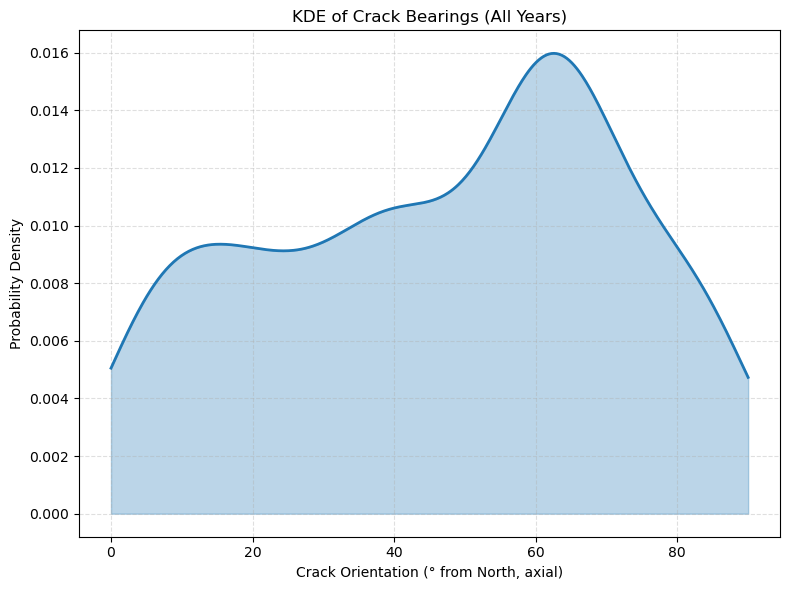

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- assuming lo has a "bearings" column containing lists or arrays of angles ---
# flatten all bearings
all_bearings = np.concatenate(lo["bearings"].values)
all_bearings = all_bearings[np.isfinite(all_bearings)]

# map to [0, 90°] range for axial data
bearings_half = all_bearings % 90

# --- KDE smoothing ---
kde = gaussian_kde(bearings_half, bw_method=0.3)  # adjust bw for smoothing
x = np.linspace(0, 90, 500)
density = kde(x)

# --- plot ---
plt.figure(figsize=(8, 6))
plt.plot(x, density, color="tab:blue", lw=2)
plt.fill_between(x, density, color="tab:blue", alpha=0.3)
plt.xlabel("Crack Orientation (° from North, axial)")
plt.ylabel("Probability Density")
plt.title("KDE of Crack Bearings (All Years)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


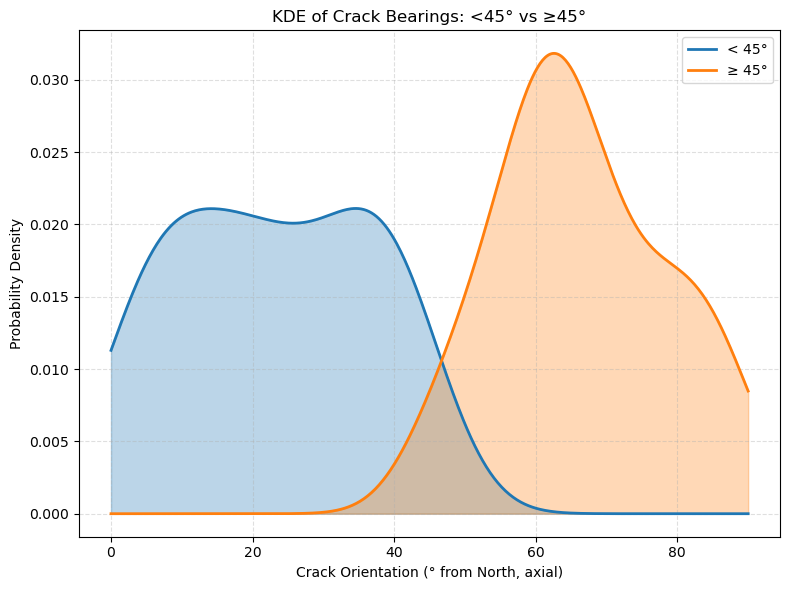

In [24]:
# --- split into two groups ---
low_angles = bearings_half[bearings_half < 45]
high_angles = bearings_half[bearings_half >= 45]

# --- KDE for each group ---
bw = 0.5  # bandwidth for smoothing
x = np.linspace(0, 90, 500)

kde_low = gaussian_kde(low_angles, bw_method=bw)
kde_high = gaussian_kde(high_angles, bw_method=bw)

density_low = kde_low(x)
density_high = kde_high(x)

# --- plot ---
plt.figure(figsize=(8, 6))

plt.plot(x, density_low, color="tab:blue", lw=2, label="< 45°")
plt.fill_between(x, density_low, color="tab:blue", alpha=0.3)

plt.plot(x, density_high, color="tab:orange", lw=2, label="≥ 45°")
plt.fill_between(x, density_high, color="tab:orange", alpha=0.3)

plt.xlabel("Crack Orientation (° from North, axial)")
plt.ylabel("Probability Density")
plt.title("KDE of Crack Bearings: <45° vs ≥45°")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

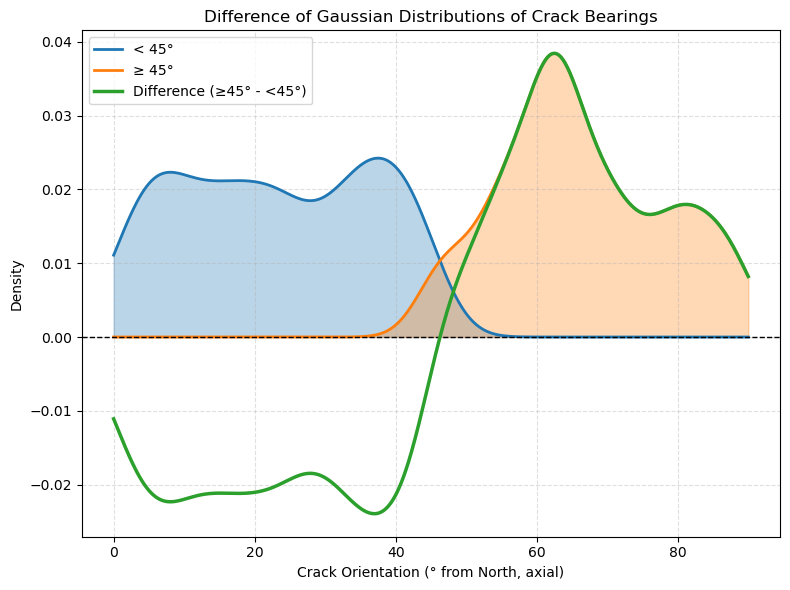

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- flatten bearings ---
all_bearings = np.concatenate(lo["bearings"].values)
all_bearings = all_bearings[np.isfinite(all_bearings)]

# Map to [0, 90°]
bearings_half = all_bearings % 90

# Split into two groups
low_angles = bearings_half[bearings_half < 45]
high_angles = bearings_half[bearings_half >= 45]

# --- KDEs for each group ---
bw = 0.3  # increase for smoother curves
kde_low = gaussian_kde(low_angles, bw_method=bw)
kde_high = gaussian_kde(high_angles, bw_method=bw)

x = np.linspace(0, 90, 500)
pdf_low = kde_low(x)
pdf_high = kde_high(x)

# --- Difference of Gaussians ---
pdf_diff = pdf_high - pdf_low  # positive = high group dominates, negative = low group dominates

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_low, color="tab:blue", lw=2, label="< 45°")
plt.plot(x, pdf_high, color="tab:orange", lw=2, label="≥ 45°")
plt.fill_between(x, pdf_low, color="tab:blue", alpha=0.3)
plt.fill_between(x, pdf_high, color="tab:orange", alpha=0.3)

# Overlay the difference as a separate curve
plt.plot(x, pdf_diff, color="tab:green", lw=2.5, label="Difference (≥45° - <45°)", zorder=3)
plt.axhline(0, color="k", ls="--", lw=1)

plt.xlabel("Crack Orientation (° from North, axial)")
plt.ylabel("Density")
plt.title("Difference of Gaussian Distributions of Crack Bearings")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
